In [44]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

In [45]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'models/{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [46]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

## 3) Reading & preparing the dataset

In [47]:
# Reading the dataset in dataframe 
main_path = 'data/raw/character_set3/'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 196125


,image,label
0,data/raw/character_set3/5/16817.png,5
1,data/raw/character_set3/5/8285.png,5
2,data/raw/character_set3/5/15737.png,5
3,data/raw/character_set3/5/8249.png,5
4,data/raw/character_set3/5/8213.png,5


In [48]:
df['label'].value_counts()

label
U    4046
E    4046
P    4046
Q    4046
H    4046
     ... 
1     573
8     573
2     573
3     573
9     573
Name: count, Length: 62, dtype: int64

3.1) Splitting the dataframe

In [49]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [50]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

3.2) Creating generators

In [51]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 102965 validated image filenames belonging to 62 classes.
Found 34322 validated image filenames belonging to 62 classes.
Found 58838 validated image filenames belonging to 62 classes.


In [52]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

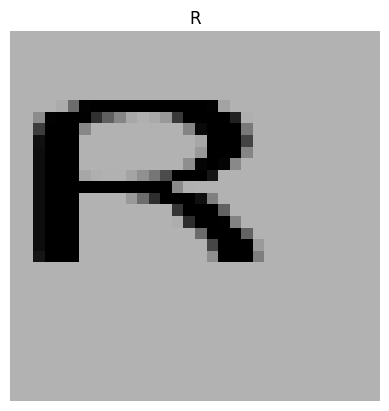

The shape of the image: (32, 32, 3)


In [53]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

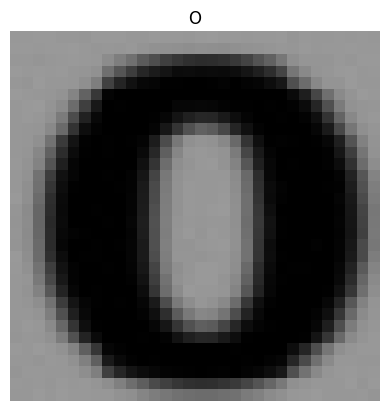

The shape of the image: (32, 32, 3)


In [54]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling

4.1) Custom CNN

In [55]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [56]:
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 62)               │        63,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,280,402 (20.14 MB)

 Trainable params: 5,280,402 (20.14 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [58]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


/home/dangazelle/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 448/3218 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.0553 - loss: 4.2427

2024-11-24 18:41:11.579153: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[21,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,128,10,10]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


3214/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4149 - loss: 2.3465

2024-11-24 18:41:48.925112: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[18,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,128,10,10]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}



Epoch 1: val_loss improved from inf to 0.58709, saving model to models/CustomCnn_model.keras
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.4152 - loss: 2.3451 - val_accuracy: 0.8443 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 2/20
3213/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8187 - loss: 0.6684
Epoch 2: val_loss improved from 0.58709 to 0.55684, saving model to models/CustomCnn_model.keras
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.8187 - loss: 0.6683 - val_accuracy: 0.8571 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 3/20
3213/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8408 - loss: 0.5791
Epoch 3: val_loss improved from 0.55684 to 0.48329, saving model to models/CustomCnn_model.keras
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8408 - loss: 0.5792 - val_accuracy: 0.8706 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 4/20
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8376 - loss: 0.6093
Epoch 4: va

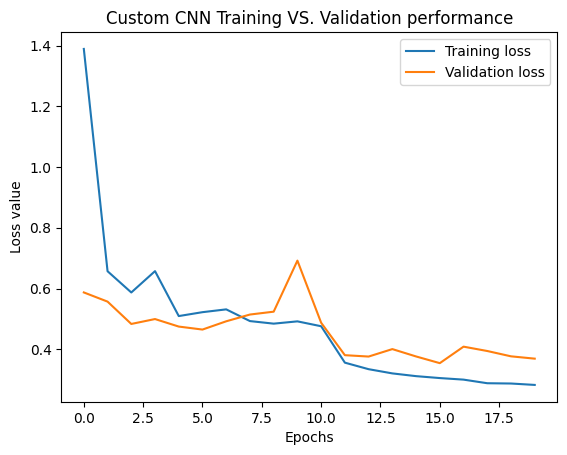

In [59]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [60]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

1836/1839 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2024-11-24 18:54:02.580792: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[22,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,128,10,10]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1839/1839 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step


In [61]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       179
           1       0.99      0.96      0.97       179
           2       0.97      1.00      0.99       180
           3       0.99      0.99      0.99       170
           4       0.99      0.97      0.98       169
           5       1.00      0.99      1.00       166
           6       1.00      1.00      1.00       189
           7       0.95      0.99      0.97       166
           8       0.99      0.98      0.98       163
           9       0.99      0.97      0.98       183
           A       0.94      0.91      0.93      1212
           B       0.96      0.91      0.94      1202
           C       0.91      0.88      0.90      1191
           D       0.94      0.92      0.93      1240
           E       0.95      0.91      0.93      1201
           F       0.95      0.89      0.92      1156
           G       0.94      0.90      0.

4.2) EfficientNetB7

In [ ]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

In [ ]:
EffNetB7.summary()

In [ ]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

4.3) MobileNetV2

In [ ]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

In [ ]:
MobNetV2.summary()

In [ ]:
# Recreate the optimizer instance
optimizer = tf.keras.optimizers.Adam()

# Compile the model with the new optimizer
MobNetV2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

4.4) VGG19

In [ ]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [ ]:
VG.summary()

In [ ]:
# Recreate the optimizer instance
opt = tf.keras.optimizers.Adam()

# Compile the model with the new optimizer
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

4.5) DenseNet121

In [ ]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

In [ ]:
Den.summary()

In [ ]:
opt = tf.keras.optimizers.Adam()

Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

# 5) Evaluation & Comparison

In [ ]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

In [ ]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Precision")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

# 6) Post-Processing

In [65]:
# Computer Vision - Low level techniques
def load_model():
    model_path = 'models/CustomCnn_model.keras'
    model = tf.keras.models.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

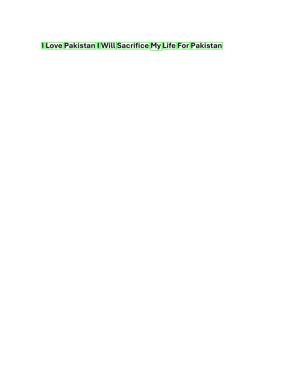

--> H LOVe PakjStan H Wjll SaCYjfjCe MY Ljfe FOY PakjStan


In [ ]:
# Testing 1 (Upper case + Lower case)
img = read_image('data/raw/character_set1/Test_5.png')
text = extract(img)
print('-->',text)

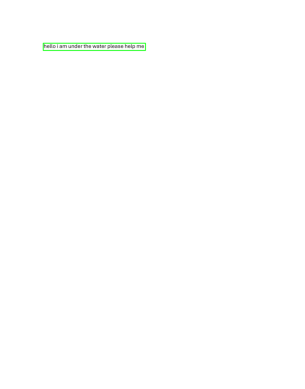

--> heLLOQamUndertheWaterpLeaseheLpme


In [73]:
# Testing 2 (Lower case)
img = read_image('data/raw/character_set1/Test_4.png')
text = extract(img)
print('-->',text)